In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import os
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight
import torch
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from torch.utils.data import Dataset, DataLoader

Taking a sample Input to test frequency

In [2]:
train_timestamp = "D:/NCSU/spring_2023/Neural Networks/terrain_prediction/TrainingData/subject_001_02__x_time.csv"
train_feature = "D:/NCSU/spring_2023/Neural Networks/terrain_prediction/TrainingData/subject_001_02__x.csv"
test_timestamp = "D:/NCSU/spring_2023/Neural Networks/terrain_prediction/TrainingData/subject_001_02__y_time.csv"
test_labels = "D:/NCSU/spring_2023/Neural Networks/terrain_prediction/TrainingData/subject_001_02__y.csv"

In [3]:
#X_features
x_time_df = pd.read_csv(train_timestamp, header=None)
x_time_df.astype('float64')
x_df = pd.read_csv(train_feature, header=None)
x_combined = pd.concat([x_time_df, x_df], axis=1, ignore_index=True)
x_combined = x_combined.rename({0:'timestamp'}, axis='columns')
x_combined.set_index('timestamp', inplace=True)

#Y_features
y_time_df = pd.read_csv(test_timestamp , header=None)
y_time_df.astype('float64')
y_df = pd.read_csv(test_labels, header=None)
y_combined = pd.concat([y_time_df, y_df], axis=1, ignore_index=True)
y_combined = y_combined.rename({0:'timestamp'}, axis='columns')
y_combined.set_index('timestamp', inplace=True)

Use Nearest timestamp sample to assign the label

In [17]:
combined = pd.merge_asof(left=x_combined, right=y_combined, left_index=True, right_index = True, direction='nearest')

In [18]:
combined.head()

,1_x,2,3,4,5,6,1_y
timestamp,,,,,,,
0.000,1.726654,9.619981,1.723327,-0.001997,0.067502,0.126057,0
0.025,2.225759,9.493385,1.782374,0.008557,0.029333,0.073573,0
0.050,2.010621,9.481603,1.770000,-0.004651,0.001009,0.062978,0
0.075,1.614272,9.516440,1.798932,0.009519,0.024405,0.032554,0
0.100,1.862582,9.353709,1.722649,0.007902,0.022794,0.020837,0


In [21]:
combined.rename(columns={'1_x':'acc_x',2:'acc_y',3:'acc_z',4:'gy_x',5:'gy_y',6:'gy_z','1_y':'terrain'}, inplace=True)

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.signal import find_peaks

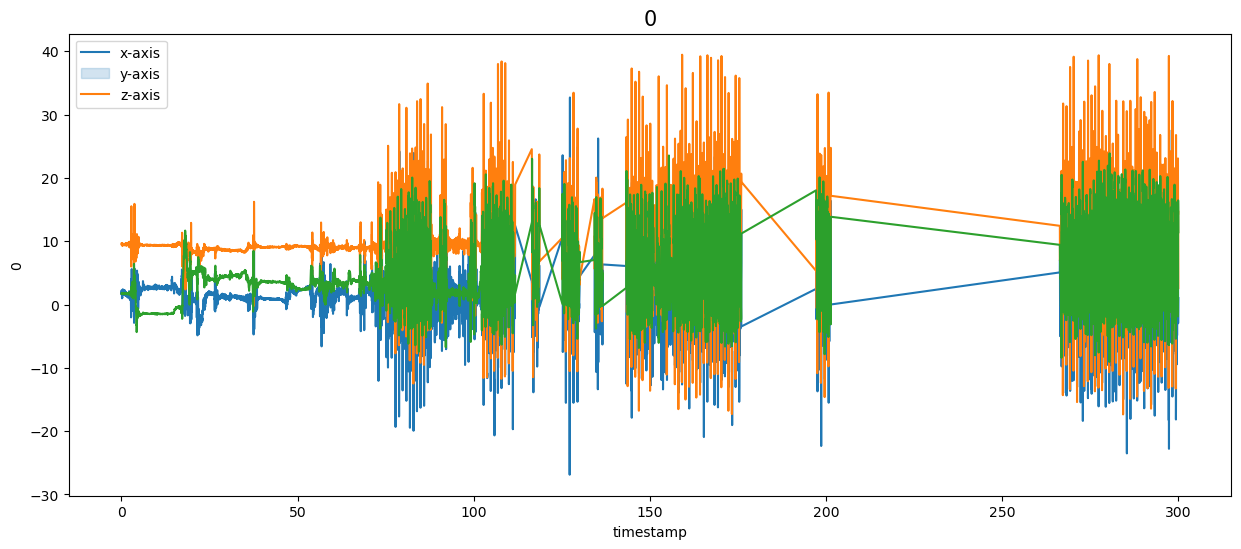

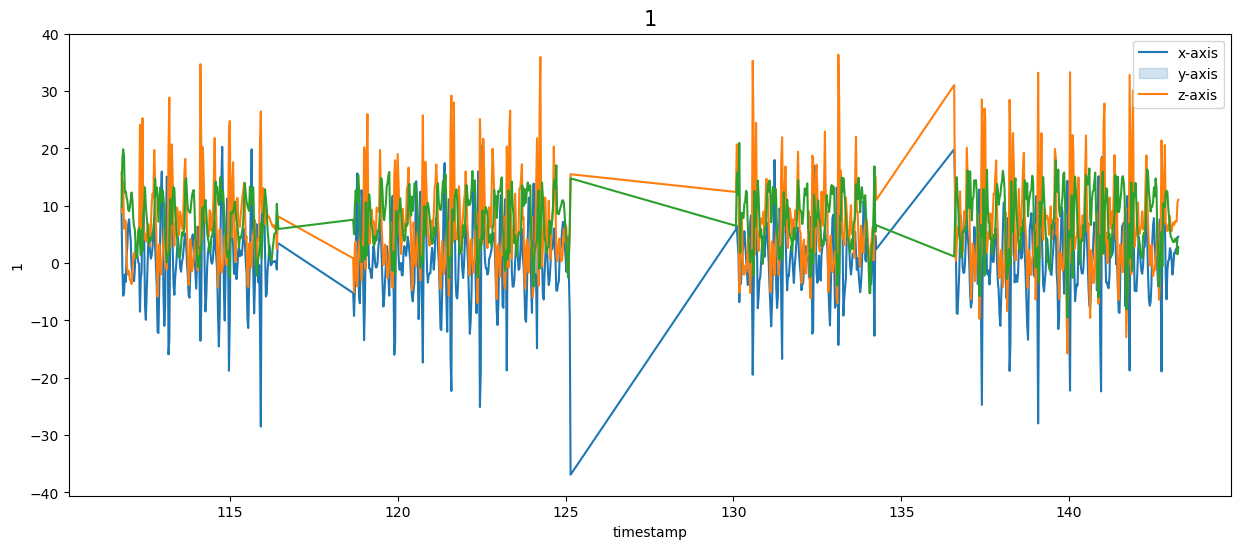

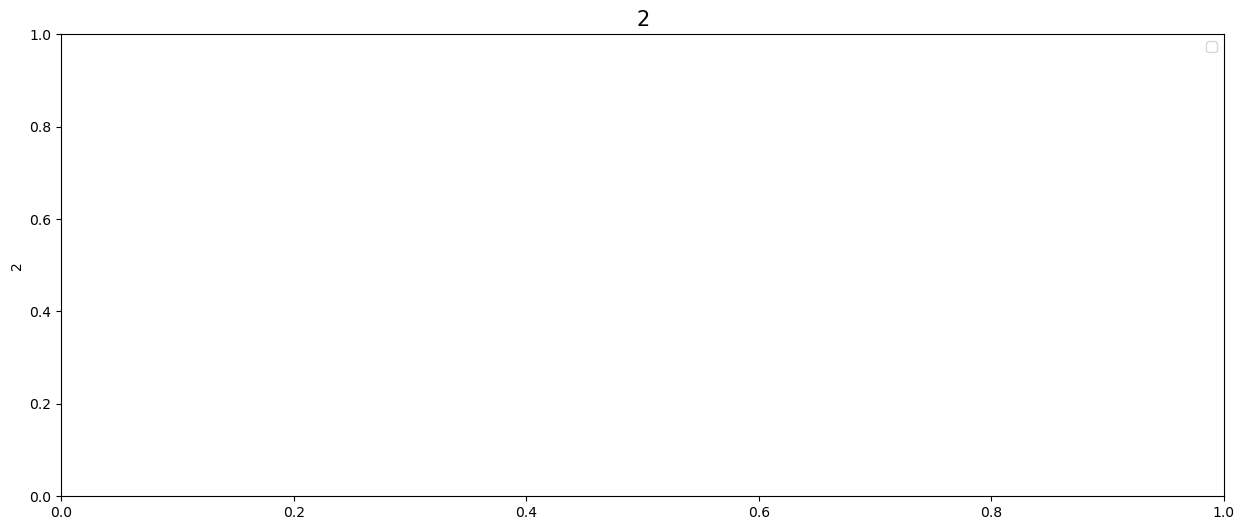

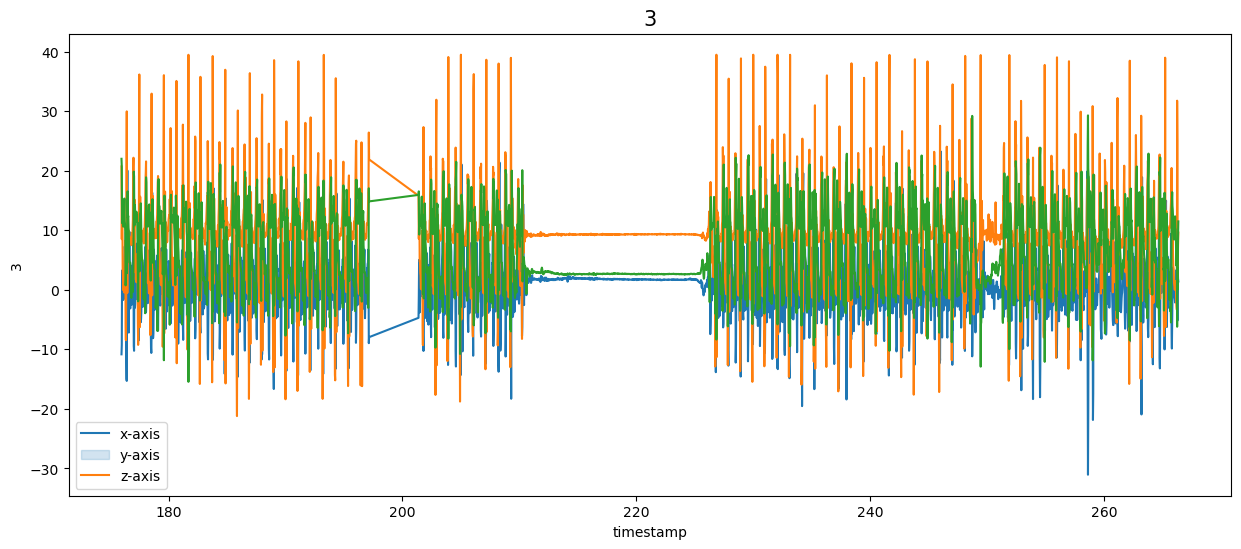

In [33]:
for i in [0,1,2,3]:
    temp_data = combined[combined['terrain'] == i][:300]
    plt.figure(figsize=(15,6))
    sns.lineplot(y='acc_x', x= temp_data.index, data=temp_data)
    sns.lineplot(y='acc_y', x= temp_data.index, data=temp_data)
    sns.lineplot(y='acc_z', x= temp_data.index, data=temp_data)
    plt.legend(['x-axis','y-axis','z-axis'])
    plt.ylabel(i)
    plt.title(i, fontsize=15)
    plt.show()

(70172, 7)

In [79]:
acc_x = []
acc_y = []
acc_z = []
train_labels = []

window_size = 30
step_size = 30

# creating overlaping windows of size window-size 100
for i in range(0, combined.shape[0], step_size):
    
    try:
        xs = combined['acc_x'].values[i: i + window_size]
        ys = combined['acc_y'].values[i: i + window_size]
        zs = combined['acc_z'].values[i: i + window_size]
        # print(stats.mode(combined['terrain'].values[i: i + window_size])[0])
        # if len(combined['terrain'][i: i + window_size]) == 0:
        # break
        if len(xs) != 30:
            print(i, len(xs))
        label = stats.mode(combined['terrain'].values[i: i + window_size]).mode[-1]

        acc_x.append(xs)
        acc_y.append(ys)
        acc_z.append(zs)
        train_labels.append(label)
    except Exception as e:
        print("Something wrong", e)

# # Statistical Features on raw x, y and z in time domain
# X_train = pd.DataFrame()

# # mean
# X_train['x_mean'] = pd.Series(acc_x).apply(lambda x: x.mean())
# X_train['y_mean'] = pd.Series(acc_y).apply(lambda x: x.mean())
# X_train['z_mean'] = pd.Series(acc_z).apply(lambda x: x.mean())

# # std dev
# X_train['x_std'] = pd.Series(acc_x).apply(lambda x: x.std())
# X_train['y_std'] = pd.Series(acc_y).apply(lambda x: x.std())
# X_train['z_std'] = pd.Series(acc_z).apply(lambda x: x.std())

# # avg absolute diff
# X_train['x_aad'] = pd.Series(acc_x).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
# X_train['y_aad'] = pd.Series(acc_y).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
# X_train['z_aad'] = pd.Series(acc_z).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

# # min
# X_train['x_min'] = pd.Series(acc_x).apply(lambda x: x.min())
# X_train['y_min'] = pd.Series(acc_y).apply(lambda x: x.min())
# X_train['z_min'] = pd.Series(acc_z).apply(lambda x: x.min())

# # max
# X_train['x_max'] = pd.Series(acc_x).apply(lambda x: x.max())
# X_train['y_max'] = pd.Series(acc_y).apply(lambda x: x.max())
# X_train['z_max'] = pd.Series(acc_z).apply(lambda x: x.max())

# # max-min diff
# X_train['x_maxmin_diff'] = X_train['x_max'] - X_train['x_min']
# X_train['y_maxmin_diff'] = X_train['y_max'] - X_train['y_min']
# X_train['z_maxmin_diff'] = X_train['z_max'] - X_train['z_min']

# # median
# X_train['x_median'] = pd.Series(acc_x).apply(lambda x: np.median(x))
# X_train['y_median'] = pd.Series(acc_y).apply(lambda x: np.median(x))
# X_train['z_median'] = pd.Series(acc_z).apply(lambda x: np.median(x))

# # median abs dev 
# X_train['x_mad'] = pd.Series(acc_x).apply(lambda x: np.median(np.absolute(x - np.median(x))))
# X_train['y_mad'] = pd.Series(acc_y).apply(lambda x: np.median(np.absolute(x - np.median(x))))
# X_train['z_mad'] = pd.Series(acc_z).apply(lambda x: np.median(np.absolute(x - np.median(x))))

# # interquartile range
# X_train['x_IQR'] = pd.Series(acc_x).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
# X_train['y_IQR'] = pd.Series(acc_y).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
# X_train['z_IQR'] = pd.Series(acc_z).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

# # negtive count
# X_train['x_neg_count'] = pd.Series(acc_x).apply(lambda x: np.sum(x < 0))
# X_train['y_neg_count'] = pd.Series(acc_y).apply(lambda x: np.sum(x < 0))
# X_train['z_neg_count'] = pd.Series(acc_z).apply(lambda x: np.sum(x < 0))

# # positive count
# X_train['x_pos_count'] = pd.Series(acc_x).apply(lambda x: np.sum(x > 0))
# X_train['y_pos_count'] = pd.Series(acc_y).apply(lambda x: np.sum(x > 0))
# X_train['z_pos_count'] = pd.Series(acc_z).apply(lambda x: np.sum(x > 0))

# # values above mean
# X_train['x_above_mean'] = pd.Series(acc_x).apply(lambda x: np.sum(x > x.mean()))
# X_train['y_above_mean'] = pd.Series(acc_y).apply(lambda x: np.sum(x > x.mean()))
# X_train['z_above_mean'] = pd.Series(acc_z).apply(lambda x: np.sum(x > x.mean()))

# # number of peaks
# X_train['x_peak_count'] = pd.Series(acc_x).apply(lambda x: len(find_peaks(x)[0]))
# X_train['y_peak_count'] = pd.Series(acc_y).apply(lambda x: len(find_peaks(x)[0]))
# X_train['z_peak_count'] = pd.Series(acc_z).apply(lambda x: len(find_peaks(x)[0]))

# # skewness
# X_train['x_skewness'] = pd.Series(acc_x).apply(lambda x: stats.skew(x))
# X_train['y_skewness'] = pd.Series(acc_y).apply(lambda x: stats.skew(x))
# X_train['z_skewness'] = pd.Series(acc_z).apply(lambda x: stats.skew(x))

# # kurtosis
# X_train['x_kurtosis'] = pd.Series(acc_x).apply(lambda x: stats.kurtosis(x))
# X_train['y_kurtosis'] = pd.Series(acc_y).apply(lambda x: stats.kurtosis(x))
# X_train['z_kurtosis'] = pd.Series(acc_z).apply(lambda x: stats.kurtosis(x))

# # energy
# X_train['x_energy'] = pd.Series(acc_x).apply(lambda x: np.sum(x**2)/100)
# X_train['y_energy'] = pd.Series(acc_y).apply(lambda x: np.sum(x**2)/100)
# X_train['z_energy'] = pd.Series(acc_z).apply(lambda x: np.sum(x**2/100))

# # avg resultant
# X_train['avg_result_accl'] = [i.mean() for i in ((pd.Series(acc_x)**2 + pd.Series(acc_y)**2 + pd.Series(acc_z)**2)**0.5)]

# # signal magnitude area
# X_train['sma'] =    pd.Series(acc_x).apply(lambda x: np.sum(abs(x)/100)) + pd.Series(acc_y).apply(lambda x: np.sum(abs(x)/100)) \
#                   + pd.Series(acc_z).apply(lambda x: np.sum(abs(x)/100))

C:\Users\sruja\AppData\Local\Temp\ipykernel_37500\3883405964.py:21: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  label = stats.mode(combined['terrain'].values[i: i + window_size]).mode[-1]


70170 2


In [81]:
len(acc_x[-1])

2

In [82]:
len(train_labels)

2340

In [49]:
len(acc_x[0])

30

In [64]:
2339 * 30

70170

In [54]:
combined['terrain'].shape[0]

70172

In [58]:
stats.mode([1,1,1]).mode[-1]

C:\Users\sruja\AppData\Local\Temp\ipykernel_37500\1752354317.py:1: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  stats.mode([1,1,1]).mode[-1]


1

In [65]:
train_labels[-1]

0

In [66]:
combined.shape[0] - window_size

70142

In [1]:
range(0, combined.shape[0], step_size)[-1]

NameError: name 'combined' is not defined

In [78]:
combined.shape

(70172, 7)